# Dynamics of the perceptron 

Variables to fix 

1. $\alpha = \frac{M}{N}$ 
2. $\sigma$ = budget 
3. $\eta$ = Var(budget) 
4. $\bar{p}$ = Average price of the goods 
5. $\Delta$ = $\bar{p^2} - \bar{p}$  :  Fluctuations of the prices around $\bar{p}$. 

A few other variables are required 

6. $\epsilon_{D}$ : Susceptibility of the demand to change based on the production 
7. $\epsilon_{p}$ : Susceptibility of the demand to changes of prices. 


In [1]:
# Fixing the variables 
import numpy as np 
import scipy 
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.integrate import quad 
from scipy.optimize import brentq, newton, ridder, bisect
%matplotlib inline 


In [405]:
alpha = 0.1
N = 3000
M = alpha*N
p_bar = 0.0
if (p_bar!=0):
    Delta = 3*p_bar**2
else:
    Delta = 0.5
eta = 0.0
# sigma = 2.0*(np.sqrt(p_bar**2 + Delta))
sigma = 2.5
eps_D = 0.1
eps_P = 0.1
if (p_bar != 0.0):
    m = 1/np.sqrt(1+(Delta/p_bar**2))
    print m
else: 
    m = 0
tol = 1e-4
step_size = 1e-4
maxiter = 500
print sigma, Delta, m

2.5 0.5 0


In [406]:
#Initialisations 
xi_matrix = np.random.randn(int(M),N)


In [407]:
prices = np.random.normal(p_bar, np.sqrt(Delta),N)
budgets = eta*np.random.randn(int(M))

In [408]:
print np.average(prices), np.std(prices)**2
print p_bar, Delta
print prices.shape

-0.0146900722339 0.513035500974
0.0 0.5
(3000,)


# Main GD loop

In [409]:
def compute_rhs(prices, sigma, budgets, p_bar):
    h_mu = ((1.0/np.sqrt(N))*xi_matrix.dot(prices)) - sigma
    temp = np.multiply(h_mu, np.heaviside(-1.0*h_mu, 0.5))
    del_h = (1.0/np.sqrt(N))*temp.dot(xi_matrix)
    A = (-1./N)*np.sum(np.multiply(prices, del_h))
    B = (-1./N)*np.sum(del_h)
    rhs = 1.0*del_h +(1.0/Delta)*(A-B*p_bar)*prices +(1.0/Delta)*(B*p_bar*p_bar - A*p_bar) - B
    return rhs


In [417]:
# rhs = compute_rhs(prices, sigma, budgets, p_bar)
# print np.linalg.norm(rhs)
# iteration_number = 0
# energy_list = []
# gradient_list = []
# converge = False 
# # while (np.linalg.norm(rhs)> tol) and (iteration_number <= maxiter) :
# # while (converge != True): 
# # for i in range(1000):
# while(np.linalg.norm(rhs) >  tol):
#     print "Iteration number {}".format(iteration_number)
#     iteration_number +=1 
#     h_mu = ((1.0/np.sqrt(N))*xi_matrix.dot(prices)) - sigma
# #     print "h_mu {} ".format(np.random.choice(h_mu, size=5))
#     energy = 0.5*np.sum(np.square(np.multiply(h_mu, np.heaviside(-1.0*h_mu, 0.5))))
#     energy = alpha*energy/M
# #     print "energy {}".format(energy) 
#     energy_list.append(energy)
# #     prices = new_prices[:]
#     prices = prices  - step_size* rhs 
# #     print "Prices {} ".format(np.random.choice(prices, size = 5)) 
#     new_rhs = compute_rhs(prices, sigma, budgets, p_bar)
#     converge = True 
#     converge = converge and (np.linalg.norm(new_rhs-rhs) < tol)
#     rhs = new_rhs
# #     print "Gradient {} ".format(np.random.choice(rhs, size=5))
# #     del_h = new_del_h[:]
# #     new_del_h = temp_del_h[:]
#     print "Grad_norm, Prices_norm, Avg_price, Std_price Energy {} {} {} {} {} ".format(np.linalg.norm(rhs), np.linalg.norm(prices),
#                                                                              np.average(prices), np.std(prices)**2, energy)
#     gradient_list.append(np.linalg.norm(rhs)/N)

(array([   8.,   44.,  175.,  405.,  701.,  791.,  564.,  226.,   72.,   14.]),
 array([-2.44721499, -1.9721808 , -1.4971466 , -1.02211241, -0.54707822,
        -0.07204403,  0.40299016,  0.87802435,  1.35305854,  1.82809274,
         2.30312693]),
 <a list of 10 Patch objects>)

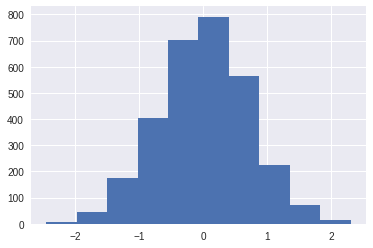

In [411]:
plt.hist(prices)

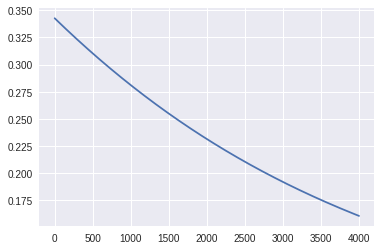

In [412]:
plt.plot(np.asarray(energy_list[:4000]))

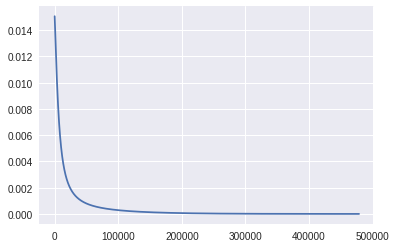

In [413]:
plt.plot(np.asarray(gradient_list[:]))

In [404]:
np.argmin(energy_list)
energy_list[np.argmin(energy_list)] - energy_analytic

1.8550507603756898

In [383]:
np.average(prices)

4.7369515717340015e-17

In [384]:
print energy_list[-1]
print gradient_list[-1]

39.4005697109
3.33136706995e-07


In [385]:
print np.std(prices)**2
print Delta

0.5
0.5


In [390]:
print energy_list[-1] - energy_analytic

11.1705552103


## Print energies

In [339]:
h_mu = xi_matrix.dot(prices) - sigma - budgets

In [340]:
energy = 0.5*np.sum(np.multiply(np.square(h_mu), np.heaviside(h_mu, 0.5)))

In [341]:
print energy

9277267.02021


## Checking energy with analytic calculation 

In [88]:
def jamming_integrand(h,sigma, eta = 0.0):
    ''' Integrand which enters for the computation of the 
        jamming line'''
    den = 1.0/np.sqrt(2*np.pi*(1+eta))
    fun = np.exp(-(h*h)/(2*(1+eta)))
    fac = (h-sigma)**2
    return fun*fac*den

def standard_integrand(h, sigma, eta):
    ''' Integrand for the second integral entering 
        the computation for the UNSAT instability'''
    den = 1.0/np.sqrt(2*np.pi*(1+eta))
    fun = np.exp(-(h*h)/(2*(1+eta)))
    return den*fun

In [89]:
def func_to_solve_UNSAT(chi,m, sigma = 0.0):
    ''' Function to compute the value of '''
    return (1-m**2)*(quad(standard_integrand, -np.inf, chi, args = (chi, sigma))[0]) - quad(jamming_integrand, -np.inf, 
                                                                                            chi, args = (chi, sigma))[0]

def compute_chi(m, sigma = 0.0):
    return newton(func_to_solve_UNSAT, 0.0, args = (m, sigma), maxiter = 500)
#     return brentq(func_to_solve_UNSAT, -4.0, 3.0, args = (m, sigma))
    

def compute_alpha_J(sigma, m, eta = 0.0):
    ''' Computes a particular value on the jamming line 
        for a given value of chi and m'''
    integral = quad(jamming_integrand, -np.inf, sigma, args = (sigma,eta))
    return (1-m**2)/integral[0]    
    
def jamming_line(sigma_range, m, eta = 0.0):
    ''' Computes the jamming line for a range of values of chi'''
    alpha = []
    for sigma in sigma_range:
        integral = quad(jamming_integrand, -np.inf, sigma, args = (sigma, eta))
        alpha.append((1-m**2)/integral[0])
    return np.asarray(alpha)

In [90]:
sigma_range = np.arange(-3,3,0.01)

In [91]:
jline = jamming_line(sigma_range, 0.0)

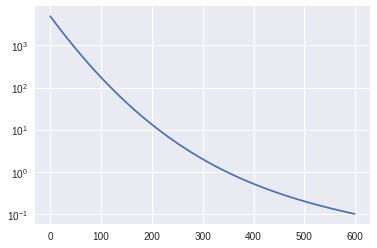

In [291]:
plt.semilogy(jline)

In [414]:
alpha_J = compute_alpha_J(sigma, m)
print alpha_J

0.13795385533


In [415]:
energy_analytic = 0.50*(1-m**2)*(np.sqrt(alpha/alpha_J) - 1)**2

In [416]:
energy_analytic

0.01104114513258826

In [295]:
extra_1 = N*p_bar/(np.sqrt(p_bar**2 + Delta))
extra_2 = m/(np.sqrt(alpha/alpha_J) - 1)
print extra_1, extra_2, extra_1*extra_2

0.0 0.0 0.0
